In [38]:
import geopandas as gpd
import rasterio
import richdem as rd
import numpy as np

import rasterio

from shapely.geometry import Point
import os

import pandas as pd

import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns

This notebook is designed to calculate slope and drainage area at points or along transects, then generate plots of slope vs drainage area.

In [39]:
def coarsen_raster (in_path, out_path, factor):
    """Coarsens the resolution of a raster by a given factor"""

    with rasterio.open(in_path) as src:
        data = src.read(1)

        height, width = data.shape
        new_height = height // factor
        new_width = width // factor

        transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )
    
        metadata = src.meta.copy()
        metadata.update({
            'height': new_height,
            'width': new_width,
            'transform': transform
        })

    # Reshape the data array for coarsening
    reshaped_data = data[:new_height * factor, :new_width * factor].reshape(new_height, factor, new_width, factor)
    
    # Average the values over the factor
    coarsened_data = reshaped_data.mean(axis=(1, 3))

    with rasterio.open(out_path, 'w', **metadata) as dst:
        dst.write(coarsened_data, 1)



def sample_neighbors(coord, var, res):
    """Samples the neighborhood raster cells around a point and returns the max value."""
    
    c = (coord[0], coord[1])
    n = (coord[0], coord[1] + res)
    ne = (coord[0] + res, coord[1] + res)
    e = (coord[0] + res, coord[1])
    se = (coord[0] + res, coord[1] - res)
    s = (coord[0], coord[1] - res)
    sw = (coord[0] - res, coord[1] - res)
    w = (coord[0] - res, coord[1])
    nw = (coord[0] - res, coord[1] + res)

    nbhd = [c, n, ne, e, se, s, sw, w, nw]
    max_val = 0

    for pt in nbhd:
        for val in var.sample([pt]):
            value = val[0]
            if value > max_val:
                max_val = value
    
    return max_val

def shp_to_gdf(shp_files):
    """Read each of a list of shapefiles and create a geodataframe for each of them."""

    gdf_list = []

    for file in shp_files:
        gdf = gpd.read_file(file)
        gdf_list.append(gdf)
    
    return gdf_list

def gdf_to_coords(gdf_list):
    """Read each of a list of gdfs and save a list of coordinates for each of them. This allows us to sample the
    rasters at each coordinate and append the values to the gdfs."""
    
    coord_list = []
    coord_lists = []

    for gdf in gdf_list:
        coord_list = [(x, y) for x, y in zip(gdf["geometry"].x, gdf["geometry"].y)]
        coord_lists.append(coord_list)

    return coord_lists

def sample_slope_area(gdf_list, coord_lists, flo, slp, neighbors=True, sample_distance=2):
    """Sample slope and area at each of the coordinates in the nested lists and append the values to the associated gdfs.
    This is currently set up to return slope, log of slope, and drainage area, as well as the snap pour area, and the log of snap pour area. 
    These snap pour values are based on the idea that our transects probably do not grab the very bottom of a channel or a water track,
    and therefore drainage area values will likely be underestimates; we sample neighboring points and return the highest value in an effort
    to correct this. If you don't want to sample neighbors, set neighbors to False.
    """
    idx = 0

    for coord_list in coord_lists:
        gdf_list[idx]['slope'] = [float(x[0]) for x in slp.sample(coord_list)]
        gdf_list[idx]['log_slope'] = np.log10(gdf_list[idx]['slope'])
        gdf_list[idx]['area'] = [float(x[0]) for x in flo.sample(coord_list)]
        indx = 0
        if neighbors:
            for coord in coord_list:
                gdf_list[idx].loc[indx, 'area_sp'] = sample_neighbors(coord, flo, sample_distance)
                gdf_list[idx].loc[indx, 'log_area_sp'] = np.log10(gdf_list[idx].loc[indx, 'area_sp'])
                indx += 1
        idx += 1

def save_csvs():
    """Save our newly sampled gdfs as csvs"""

    idx = 0
    csv_files = [] 

    for shp_file in shp_files:
        path_base = os.path.basename(shp_file)[:-4]
        gdf_list[idx].to_csv(f"csvs/{path_base}.csv")
        csv_files.append(f"csvs/{path_base}.csv")

        idx += 1

The next block of code brings in your dem, which should be saved to your rasters folder, then coarsens it by a given factor, and calculates slope and drainage area across the raster, savinf these new rasters as tif files. 

All you should need to change are the first three lines, where you should put the filename of your dem raster, the basename of your output files, and the factor by which you want to coarsen your dem.

In [40]:
# These are the things that you change
dem_filename = 'seward_lidar.tif'
out_basename = 'seward'
coarse_factor = 2

# Coarsen the DEM by a given factor
coarsen_raster(f"rasters/{dem_filename}", f"rasters/{out_basename}_smooth.tif", coarse_factor)

# Bring in coarsened DEM
dem_path = f"rasters/{out_basename}_smooth.tif"

elev = rd.LoadGDAL(dem_path, no_data=-9999)

# Calculate slope and drainage area and save them to tif files.
slope = rd.TerrainAttribute(elev, attrib='slope_degrees')
flowacc = rd.FlowAccumulation(elev, method='Dinf')

rd.SaveGDAL(f"rasters/{out_basename}_slope.tif", slope)
rd.SaveGDAL(f"rasters/{out_basename}_flowacc.tif", flowacc)

# Open the new raster data
slp = rasterio.open(f"rasters/{out_basename}_slope.tif")
flo = rasterio.open(f"rasters/{out_basename}_flowacc.tif")


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 1.73339                         ] (29% - 4.2s - 1 threads))

A Tarboton (1997) Flow Accumulation (aka D-Infinity, D∞)
C Tarboton, D.G., 1997. A new method for the determination of flow directions and upslope areas in grid digital elevation models. Water resources research 33, 309–319.

[===============                                   ] (30% - 26.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 31069524
p Calculating flow accumulation...
t Wall-time       = 3.09831 s                 ] (30% - 4.8s - 1 threads))


This next block requires a list of your point shapefiles to be sampled, it will read these in as gdfs, then sample slope and drainage area at each of your points. 

In [41]:
# Create the sampling points and store them in a list
shp_files = [
    "shapefiles/wt_swd_pts.shp",
    "shapefiles/gly_swd_pts.shp",
]
sample_dist = 2

gdf_list = shp_to_gdf(shp_files)
coord_lists = gdf_to_coords(gdf_list)

sample_slope_area(gdf_list, coord_lists, flo, slp, neighbors=True, sample_distance=sample_dist)


This plotting section is probably the one you'll want to spend the most time messing with on your own. I currently have this set up to create two types of plots, each under the assumption that you are comparing multiple samples of each of two categories. plot_type='scatter' will create a scatter plot of binned average values, and plot_type='regression' will create a linear regression plot with raw points scattered beneath.

If any of this isn't the kind of plotting you are looking to do, I would encourage you to check out the matplotlib and seaborn docs to develop your own plots, or even just confidently edit the plot settings I have set up here. I intend to come back to this to add a little bit more flexibility to the existing code, but this is what I've got for now.

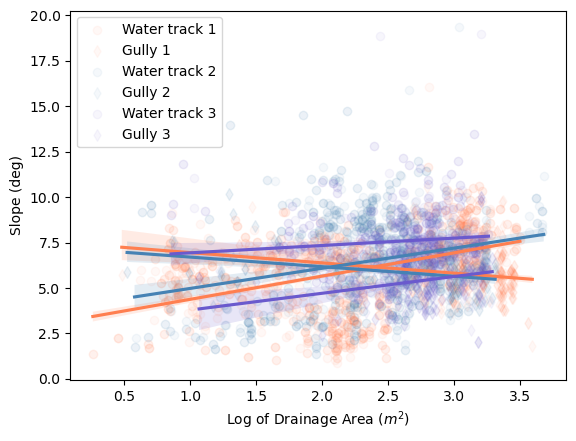

In [42]:
plot_type = 'regression'
colors = ['coral', 'steelblue', 'slateblue', 'peru', 'blue', 'red']
markers = ['o', 'd']
labels = ['Water track', 'Gully']
x_val = 'log_area_sp'
y_val = 'slope'

fig, ax = plt.subplots()
idx = 0
clr_idx = 0

for num in range(1, 4):
    for gdf in gdf_list[:]:
        filt = gdf['ORIG_FID'] == num
        filt_data = gdf[filt]

        if plot_type == 'scatter':
            x = filt_data[x_val]
            y = filt_data[y_val]

            log_bins = np.logspace(np.log10(x.min()), np.log10(x.max()), num=10)
            bin_medians, bin_edges, binnumber = sts.binned_statistic(x, y, statistic='median', bins=log_bins)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

            ax = sns.scatterplot(x=bin_centers, y=bin_medians, 
                                color=colors[clr_idx], 
                                marker=markers[idx % 2], 
                                label=f"{labels[idx % 2]} {clr_idx + 1}"
                                )
        elif plot_type == 'regression':
            ax = sns.regplot(data=filt_data, 
                            x=x_val, 
                            y=y_val, 
                            label=f"{labels[idx % 2]} {num}", 
                            color=colors[num - 1], 
                            scatter_kws={'alpha':0.05},
                            marker=markers[idx % 2]
                            )
        else:
            print("Please select a valid plot type, either 'scatter' or 'regression', or build your own plot using matplotlib.")
        idx += 1
    clr_idx += 1

ax.set_xlabel('Log of Drainage Area ($m^2$)')
ax.set_ylabel('Slope (deg)')
ax.legend()
